In [ ]:
#pip install transformers datasets pandas scikit-learn

In [9]:
# CLEAR CACHE 
import gc
import torch
gc.collect()

torch.cuda.empty_cache()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hassmady/.local/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
20,0.660700,0.438828
40,0.463900,0.474797
60,0.423200,0.440848
80,0.404700,0.389768
100,0.347800,0.289232
120,0.307900,0.220626
140,0.222400,0.146323
160,0.172200,0.162785
180,0.175200,0.132580
200,0.137600,0.117815


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Overall Precision: 0.8843
Overall Recall: 0.8295
Overall F1 Score: 0.8560
Overall Accuracy: 0.9280
              precision    recall  f1-score   support

 Non-Violent       0.94      0.96      0.95       371
     Violent       0.88      0.83      0.86       129

    accuracy                           0.93       500
   macro avg       0.91      0.90      0.90       500
weighted avg       0.93      0.93      0.93       500

Elapsed time: 0 hours, 10 minutes, 47.38 seconds

Misclassified Test Sentences:
--------------------------------------------------
Sentence: 
At first Tisaphernes was afraid of Agesilaüs, and made a treaty in which he promised him to make the Greek cities free and independent of the King. Afterwards, however, when he was convinced that he had a sufficient force, he declared war, and Agesilaüs gladly accepted it.
Actual Label: Non-Violent | Predicted Label: Violent
--------------------------------------------------
Sentence: 
But since it proved too hard a task to brea

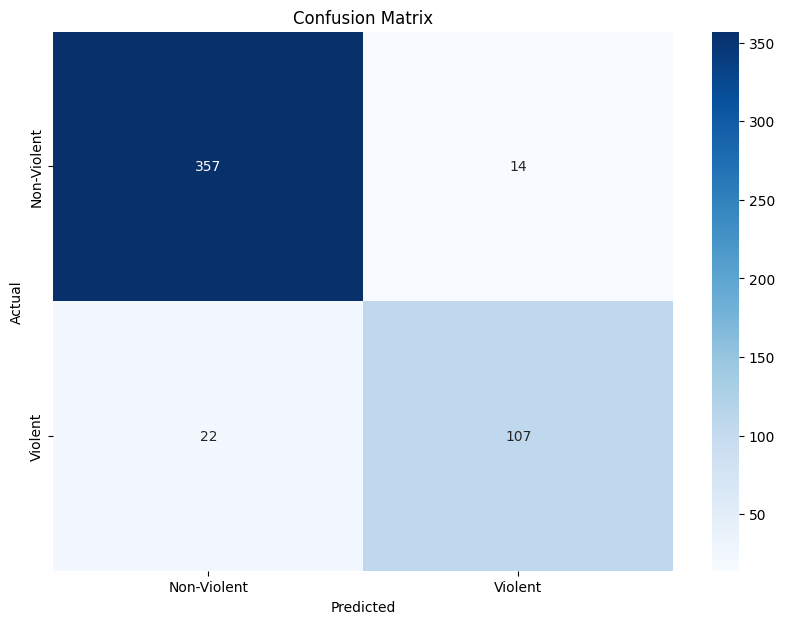

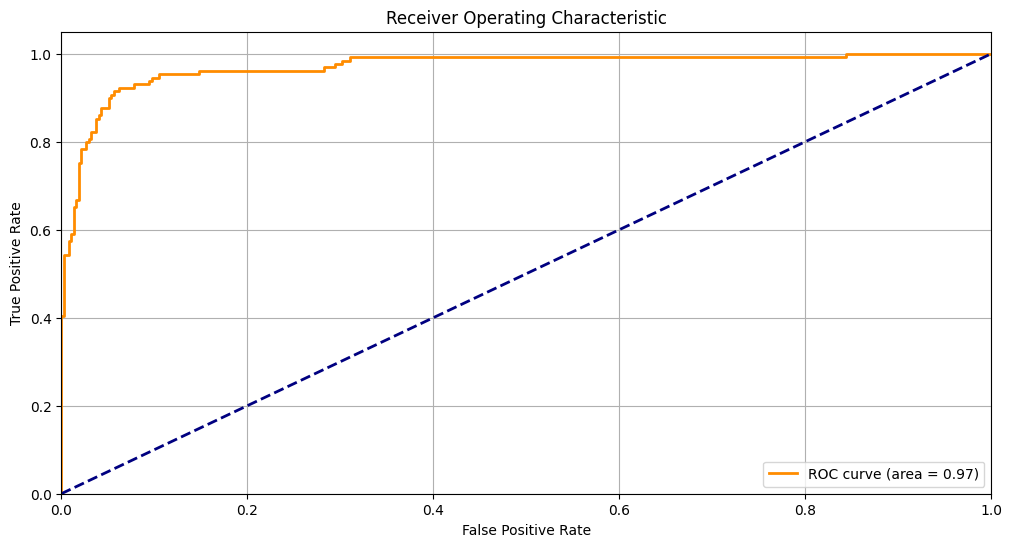

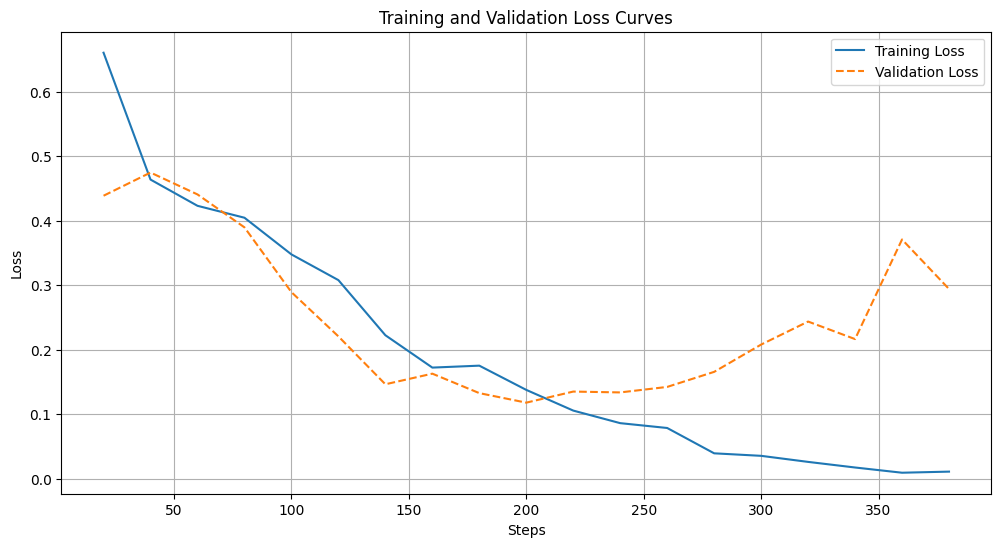

Predictions for New Sentences:
--------------------------------------------------
Sentence: 
This is a peaceful example.
Predicted Label: Non-Violent
--------------------------------------------------
Sentence: 
He killed and beheaded all enemies.
Predicted Label: Violent
--------------------------------------------------
Training and evaluation loss values have been saved to 'training_eval_loss.csv'.


In [6]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, set_seed
from datasets import Dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import random
from transformers import TrainerCallback

# Custom callback to log losses
class LogCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.eval_losses = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.training_losses.append((state.global_step, logs['loss']))
        if 'eval_loss' in logs:
            self.eval_losses.append((state.global_step, logs['eval_loss']))


start_time = time.time()

# Load the dataset
train_file_path = 'history_train_simplified.csv'  # Update with the correct file path
test_file_path = 'history_test.csv'  # Update with the correct file path

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Split the training data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_df['Text'], train_df['Violence'], test_size=0.2, random_state=42)
test_texts = test_df['Text']
test_labels = test_df['Violence']

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

# Tokenize the text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Convert to Dataset object
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'label': list(train_labels)})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'label': list(val_labels)})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'label': list(test_labels)})

# Define the model
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=15,             # number of training epochs
    per_device_train_batch_size=16,   # batch size for training
    per_device_eval_batch_size=4,    # batch size for evaluation
    warmup_steps=1700,                # number of warmup steps for learning rate scheduler
    weight_decay=0.001,              # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=20,                # log every 25 steps
    save_steps=10000,                  # save checkpoint every 10000 steps
    evaluation_strategy="steps",     # evaluate every epoch (when evaluation_strategy="epoch") or every steps if (when evaluation_strategy="steps")
)

# Initialize the custom callback
log_callback = LogCallback()

# Define Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    callbacks=[log_callback]             # add the custom callback
)

# Train the model
trainer.train()

# Evaluate the model on the test set
predictions = trainer.predict(test_dataset)

# Convert predictions to label IDs
pred_labels = np.argmax(predictions.predictions, axis=1)

# Calculate overall metrics
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)
accuracy = accuracy_score(test_labels, pred_labels)

print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1 Score: {f1:.4f}')
print(f'Overall Accuracy: {accuracy:.4f}')

# Generate classification report for both classes
report = classification_report(test_labels, pred_labels, target_names=['Non-Violent', 'Violent'])
print(report)

end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

# Print misclassified test sentences with their predicted and actual labels
test_sentences = list(test_texts)
print("\nMisclassified Test Sentences:")
print("-" * 50)
for sentence, actual_label, predicted_label in zip(test_sentences, test_labels, pred_labels):
    if actual_label != predicted_label:
        print(f"Sentence: \n{sentence}\nActual Label: {'Violent' if actual_label == 1 else 'Non-Violent'} | Predicted Label: {'Violent' if predicted_label == 1 else 'Non-Violent'}")
        print("-" * 50)

# Define a function to classify new sentences
def classify_new_sentences(sentences, model, tokenizer):
    # Tokenize the new sentences
    encodings = tokenizer(sentences, truncation=True, padding=True, return_tensors='pt')
    
    # Move to device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    encodings = {key: val.to(device) for key, val in encodings.items()}
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
    
    # Convert logits to probabilities and then to labels
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = torch.argmax(probs, dim=1).cpu().numpy()
    
    return pred_labels

# Plot confusion matrix
def plot_confusion_matrix(test_labels, pred_labels):
    cm = confusion_matrix(test_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violent', 'Violent'], yticklabels=['Non-Violent', 'Violent'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC curve
def plot_roc_curve(test_labels, predictions):
    fpr, tpr, _ = roc_curve(test_labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot loss curves
def plot_loss_curves(training_losses, eval_losses):
    training_steps, training_loss_values = zip(*training_losses)
    eval_steps, eval_loss_values = zip(*eval_losses)
    
    plt.figure(figsize=(12, 6))
    plt.plot(training_steps, training_loss_values, label='Training Loss')
    plt.plot(eval_steps, eval_loss_values, label='Validation Loss', linestyle='--')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

# Extract losses from logs
training_losses = log_callback.training_losses
eval_losses = log_callback.eval_losses

# Plot the confusion matrix
plot_confusion_matrix(test_labels, pred_labels)

# Plot the ROC curve
plot_roc_curve(test_labels, predictions.predictions)

# Plot the loss curves
plot_loss_curves(training_losses, eval_losses)

# Example usage for new sentence classification
new_sentences = [
    "This is a peaceful example.",
    "He killed and beheaded all enemies."
]
pred_labels = classify_new_sentences(new_sentences, model, tokenizer)

# Print predictions with better formatting
print("Predictions for New Sentences:")
print("-" * 50)
for sentence, label in zip(new_sentences, pred_labels):
    print(f"Sentence: \n{sentence}\nPredicted Label: {'Violent' if label == 1 else 'Non-Violent'}")
    print("-" * 50)

# Save the training and evaluation loss values to a CSV file for further analysis
loss_data = {
    'training_steps': [step for step, _ in training_losses],
    'training_loss': [loss for _, loss in training_losses],
    'eval_steps': [step for step, _ in eval_losses],
    'eval_loss': [loss for _, loss in eval_losses],
}
loss_df = pd.DataFrame(loss_data)
loss_df.to_csv('training_eval_loss.csv', index=False)

# Print the path to the saved loss data
print("Training and evaluation loss values have been saved to 'training_eval_loss.csv'.")


## Save Model and Tokenizer

In [5]:
# Save the trained model and tokenizer
model.save_pretrained('./saved_model_Roberta_large_train_Test_NO_AUGMENTATION_better')
tokenizer.save_pretrained('./saved_model_Roberta_large_train_Test_NO_AUGMENTATION_better')


('./saved_model_Roberta_large_train_Test_NO_AUGMENTATION_better/tokenizer_config.json',
 './saved_model_Roberta_large_train_Test_NO_AUGMENTATION_better/special_tokens_map.json',
 './saved_model_Roberta_large_train_Test_NO_AUGMENTATION_better/vocab.json',
 './saved_model_Roberta_large_train_Test_NO_AUGMENTATION_better/merges.txt',
 './saved_model_Roberta_large_train_Test_NO_AUGMENTATION_better/added_tokens.json')

## Load Model

In [3]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, set_seed
from datasets import Dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import random


# Load the saved model and tokenizer
model_path = './saved_model_Roberta_large_augmented'
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)

## Test on the test set

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Overall Precision on Test Set: 0.8843
Overall Recall on Test Set: 0.8295
Overall F1 Score on Test Set: 0.8560
Overall Accuracy on Test Set: 0.9280
              precision    recall  f1-score   support

 Non-Violent       0.94      0.96      0.95       371
     Violent       0.88      0.83      0.86       129

    accuracy                           0.93       500
   macro avg       0.91      0.90      0.90       500
weighted avg       0.93      0.93      0.93       500



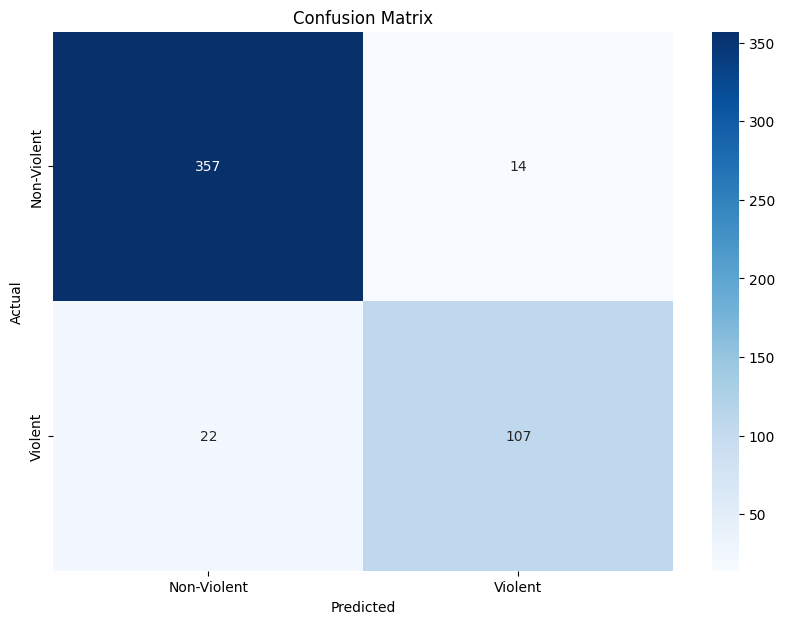

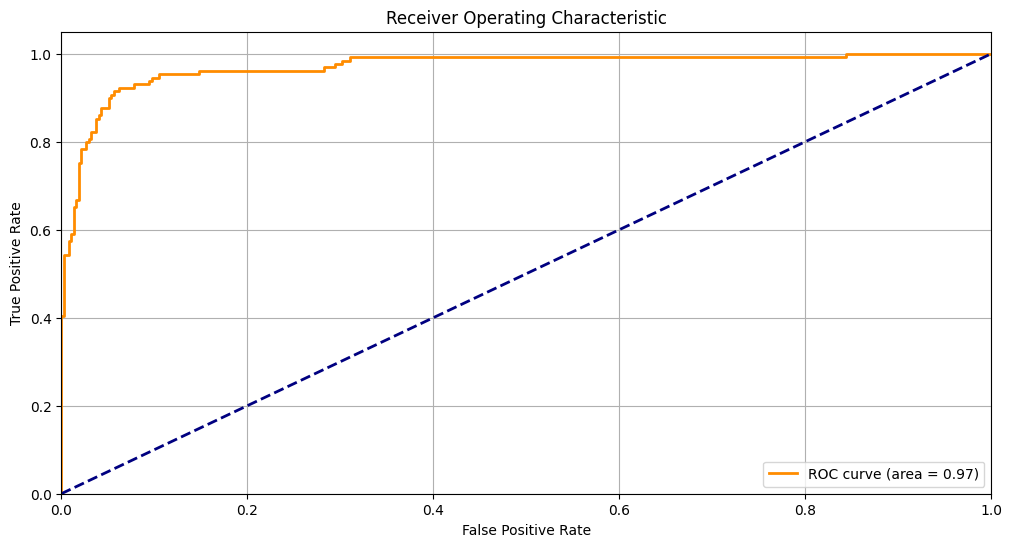


Misclassified Test Sentences:
--------------------------------------------------
Sentence: 
At first Tisaphernes was afraid of Agesilaüs, and made a treaty in which he promised him to make the Greek cities free and independent of the King. Afterwards, however, when he was convinced that he had a sufficient force, he declared war, and Agesilaüs gladly accepted it.
Actual Label: Non-Violent | Predicted Label: Violent
--------------------------------------------------
Sentence: 
But since it proved too hard a task to break the Theban front, they were forced to do what at the outset they were loth to do. They opened their ranks and let the enemy pass through, and then, when these had got clear, and were already marching in looser array, the Spartans followed on the run and smote them on the flanks. They could not, however, put them to rout, but the Thebans withdrew to Mount Helicon, From the slopes of which they had advanced to the battle. greatly elated over the battle, in which, as they

In [10]:
# Evaluate the model on the test set
predictions_test_set = trainer.predict(test_dataset)

# Convert predictions to label IDs
pred_labels_test_set = np.argmax(predictions_test_set.predictions, axis=1)

# Calculate overall metrics
precision_test_set = precision_score(test_labels, pred_labels_test_set)
recall_test_set = recall_score(test_labels, pred_labels_test_set)
f1_test_set = f1_score(test_labels, pred_labels_test_set)
accuracy_test_set = accuracy_score(test_labels, pred_labels_test_set)

print(f'Overall Precision on Test Set: {precision_test_set:.4f}')
print(f'Overall Recall on Test Set: {recall_test_set:.4f}')
print(f'Overall F1 Score on Test Set: {f1_test_set:.4f}')
print(f'Overall Accuracy on Test Set: {accuracy_test_set:.4f}')

# Generate classification report for both classes
report_test_set = classification_report(test_labels, pred_labels_test_set, target_names=['Non-Violent', 'Violent'])
print(report_test_set)

# Plot the confusion matrix for the test set
plot_confusion_matrix(test_labels, pred_labels_test_set)

# Plot the ROC curve for the test set
plot_roc_curve(test_labels, predictions_test_set.predictions)

# Print misclassified test sentences with their predicted and actual labels
test_sentences = list(test_texts)
print("\nMisclassified Test Sentences:")
print("-" * 50)
for sentence, actual_label, predicted_label in zip(test_sentences, test_labels, pred_labels_test_set):
    if actual_label != predicted_label:
        print(f"Sentence: \n{sentence}\nActual Label: {'Violent' if actual_label == 1 else 'Non-Violent'} | Predicted Label: {'Violent' if predicted_label == 1 else 'Non-Violent'}")
        print("-" * 50)


## Test on the whole data

In [ ]:
# Combine training and test datasets
whole_texts = list(train_texts) + list(test_texts)
whole_labels = list(train_labels) + list(test_labels)

# Tokenize the whole dataset
whole_encodings = tokenizer(whole_texts, truncation=True, padding=True)
whole_dataset = Dataset.from_dict({'input_ids': whole_encodings['input_ids'], 'attention_mask': whole_encodings['attention_mask'], 'label': whole_labels})

# Evaluate the model on the whole dataset
predictions_whole_set = trainer.predict(whole_dataset)

# Convert predictions to label IDs
pred_labels_whole_set = np.argmax(predictions_whole_set.predictions, axis=1)

# Calculate overall metrics
precision_whole_set = precision_score(whole_labels, pred_labels_whole_set)
recall_whole_set = recall_score(whole_labels, pred_labels_whole_set)
f1_whole_set = f1_score(whole_labels, pred_labels_whole_set)
accuracy_whole_set = accuracy_score(whole_labels, pred_labels_whole_set)

print(f'Overall Precision on Whole Set: {precision_whole_set:.4f}')
print(f'Overall Recall on Whole Set: {recall_whole_set:.4f}')
print(f'Overall F1 Score on Whole Set: {f1_whole_set:.4f}')
print(f'Overall Accuracy on Whole Set: {accuracy_whole_set:.4f}')

# Generate classification report for both classes
report_whole_set = classification_report(whole_labels, pred_labels_whole_set, target_names=['Non-Violent', 'Violent'])
print(report_whole_set)

# Plot the confusion matrix for the whole dataset
plot_confusion_matrix(whole_labels, pred_labels_whole_set)

# Plot the ROC curve for the whole dataset
plot_roc_curve(whole_labels, predictions_whole_set.predictions)

# Print misclassified sentences with their predicted and actual labels for the whole dataset
print("\nMisclassified Sentences in Whole Dataset:")
print("-" * 50)
for sentence, actual_label, predicted_label in zip(whole_texts, whole_labels, pred_labels_whole_set):
    if actual_label != predicted_label:
        print(f"Sentence: \n{sentence}\nActual Label: {'Violent' if actual_label == 1 else 'Non-Violent'} | Predicted Label: {'Violent' if predicted_label == 1 else 'Non-Violent'}")
        print("-" * 50)


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


## Predict New input

In [7]:
import torch
# Define a function to classify new sentences
def classify_new_sentences(sentences, model, tokenizer):
    # Tokenize the new sentences
    encodings = tokenizer(sentences, truncation=True, padding=True, return_tensors='pt')
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    encodings = {key: val.to(device) for key, val in encodings.items()}
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
    
    # Convert logits to probabilities and then to labels
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = torch.argmax(probs, dim=1).cpu().numpy()
    
    return pred_labels

# Example usage
new_sentences = [
   
    # George Orwell
    "The most effective way to destroy people is to deny and obliterate their own understanding of their history.",
    # Dan Brown
    "History is always written by the winners. When two cultures clash, the loser is obliterated, and the winner writes the history books. Books, which glorify their own cause and disparage the conquered foe. As Napoleon once said, what is history, but a fable agreed upon? ",
    # Sun Tzu
    "If you know the enemy and know yourself, you need not fear the result of a hundred battles. If you know yourself but not the enemy, for every victory gained you will also suffer a defeat. If you know neither the enemy nor yourself, you will succumb in every battle.",
    # Winston Churchill
    "We shall defend our island, whatever the cost may be, we shall fight on the beaches, we shall fight on the landing grounds, we shall fight in the fields and in the streets, we shall fight in the hills; we shall never surrender.",
    # Robert Kennedy
    "What has violence ever accomplished? What has it ever created? No martyr's cause has ever been stilled by an assassin's bullet. No wrongs have ever been righted by riots and civil disorders. A sniper is only a coward, not a hero; and an uncontrolled or uncontrollable mob is only the voice of madness, not the voice of the people.",
    
    
    "While the Romans were in such difficulties, the barbarians suddenly surrounded them on all sides at once, coming through the densest thickets, as they were acquainted with the paths. At first they hurled their volleys from a distance; then, as no one defended himself and many were wounded, they approached closer to them. For the Romans were not proceeding in any regular order, but were mixed in helter-skelter with the waggons and the unarmed, and so, being unable to form readily anywhere in a body, and being fewer at every point than their assailants, they suffered greatly and could offer no resistance at all.",
    "In the battle, the knight broke the lines and slaughtered his enemies and then beheaded the king.",
    "I have a dream that my four little children will one day live in a nation where they will not be judged by the color of their skin but by the content of their character.",
    "You can fool all of the people some of the time, and some of the people all of the time, but you can't fool all of the people all of the time.",
    "Battles are won by slaughter and maneuver. The greater the general, the more he contributes in maneuver, the less he demands in slaughter.",
    "Remembering the loss of those Irishmen from all parts of the island who were sent to their deaths in the imperialist slaughter of the First World War is crucial to understanding our history. It is also important to recognise the special significance in which the Battle of the Somme and the First World War is held.",
    "In the battle, the soldiers started counting the sheeps that they got as a reward for their awersome performance. They managed to cheer the crowds and support the winners ",
    "The knight killed her and her mother watched in pain as he beheads her",
    "The knight kissed her and she loved it. Then we went walking and talked about some love stories",
    
]
pred_labels = classify_new_sentences(new_sentences, model, tokenizer)


# Print predictions with better formatting
print("Predictions for New Sentences:")
print("-" * 50)
for sentence, label in zip(new_sentences, pred_labels):
    print(f"Sentence: \n{sentence}\nPredicted Label: {'Violent' if label == 1 else 'Non-Violent'}")
    print("-" * 50)

Predictions for New Sentences:
--------------------------------------------------
Sentence: 
The most effective way to destroy people is to deny and obliterate their own understanding of their history.
Predicted Label: Non-Violent
--------------------------------------------------
Sentence: 
History is always written by the winners. When two cultures clash, the loser is obliterated, and the winner writes the history books. Books, which glorify their own cause and disparage the conquered foe. As Napoleon once said, what is history, but a fable agreed upon? 
Predicted Label: Non-Violent
--------------------------------------------------
Sentence: 
If you know the enemy and know yourself, you need not fear the result of a hundred battles. If you know yourself but not the enemy, for every victory gained you will also suffer a defeat. If you know neither the enemy nor yourself, you will succumb in every battle.
Predicted Label: Non-Violent
--------------------------------------------------


## Parameter Number

In [8]:
print(f'{sum(p.numel() for p in model.parameters())}')

355361794


## Trying without Finetuning

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Overall Precision: 0.1972
Overall Recall: 0.9804
Overall F1 Score: 0.3284
Overall Accuracy: 0.2027
              precision    recall  f1-score   support

 Non-Violent       0.67      0.01      0.02       411
     Violent       0.20      0.98      0.33       102

    accuracy                           0.20       513
   macro avg       0.43      0.50      0.17       513
weighted avg       0.57      0.20      0.08       513

Elapsed time: 0 hours, 0 minutes, 14.91 seconds

Misclassified Test Sentences:
--------------------------------------------------
Sentence: 
However this may be, when Demosthenes came of age he began to bring suits against his guardians and to write speeches attacking them. They devised many evasions and new trials, but Demosthenes, after practising himself in these exercises, as Thucydides says,  not without toil and danger, won his cause, although he was able to recover not even a small fraction of his patrimony. However, he acquired sufficient practice and confiden

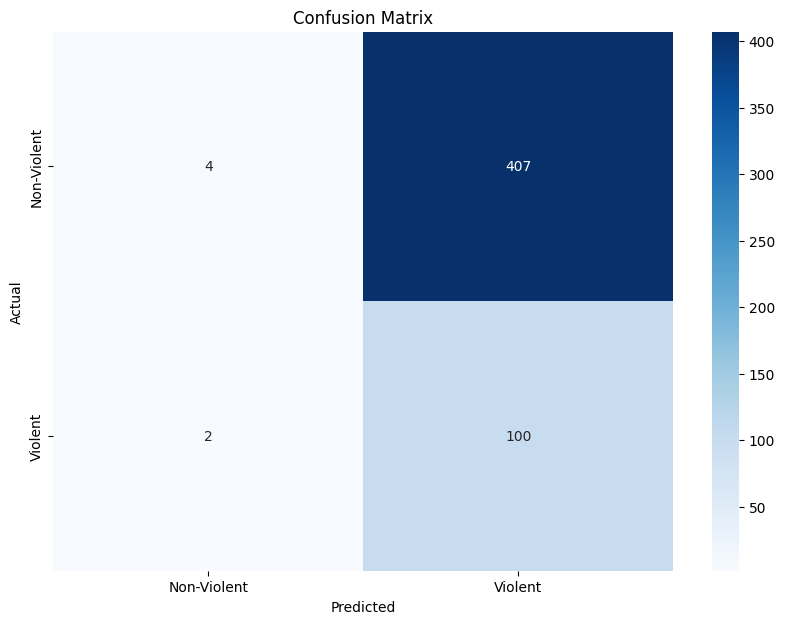

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [13]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, set_seed
from datasets import Dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import random

# Set seeds for reproducibility
def set_all_seeds(seed):
    import random
    import numpy as np
    import torch
    from transformers import set_seed

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)

set_all_seeds(42)

start_time = time.time()
# Load the dataset
file_path = 'cleaned_history_text.csv'  # Update with the correct file path
df = pd.read_csv(file_path)

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['Violence'], test_size=0.2, random_state=42)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

# Tokenize the text
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Convert to Dataset object
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'label': list(test_labels)})

# Load the pre-trained model
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)

# Function to classify new sentences
def classify_new_sentences(sentences, model, tokenizer):
    # Tokenize the new sentences
    encodings = tokenizer(sentences, truncation=True, padding=True, return_tensors='pt')
    
    # Move to device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    encodings = {key: val.to(device) for key, val in encodings.items()}
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
    
    # Convert logits to probabilities and then to labels
    probs = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = torch.argmax(probs, dim=1).cpu().numpy()
    
    return pred_labels

# Evaluate the pre-trained model on the test set
test_texts_list = list(test_texts)
pred_labels = classify_new_sentences(test_texts_list, model, tokenizer)

# Calculate overall metrics
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)
accuracy = accuracy_score(test_labels, pred_labels)

print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1 Score: {f1:.4f}')
print(f'Overall Accuracy: {accuracy:.4f}')

# Generate classification report for both classes
report = classification_report(test_labels, pred_labels, target_names=['Non-Violent', 'Violent'])
print(report)

end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")


# Print misclassified test sentences with their predicted and actual labels
print("\nMisclassified Test Sentences:")
print("-" * 50)
for sentence, actual_label, predicted_label in zip(test_texts_list, test_labels, pred_labels):
    if actual_label != predicted_label:
        print(f"Sentence: \n{sentence}\nActual Label: {'Violent' if actual_label == 1 else 'Non-Violent'} | Predicted Label: {'Violent' if predicted_label == 1 else 'Non-Violent'}")
        print("-" * 50)

# Plot confusion matrix
def plot_confusion_matrix(test_labels, pred_labels):
    cm = confusion_matrix(test_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Violent', 'Violent'], yticklabels=['Non-Violent', 'Violent'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot ROC curve
def plot_roc_curve(test_labels, predictions):
    fpr, tpr, _ = roc_curve(test_labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(test_labels, pred_labels)

# Since we are using a pre-trained model without fine-tuning, predictions will be logits
pred_probs = np.array([torch.nn.functional.softmax(torch.tensor(logits), dim=0).numpy() for logits in model(**tokenizer(test_texts_list, return_tensors='pt', padding=True, truncation=True)).logits])

# Plot the ROC curve
plot_roc_curve(test_labels, pred_probs)

# Example usage for new sentence classification
new_sentences = [
    "This is a peaceful example.",
    "He killed and beheaded all enemies."
]
pred_labels = classify_new_sentences(new_sentences, model, tokenizer)

# Print predictions with better formatting
print("Predictions for New Sentences:")
print("-" * 50)
for sentence, label in zip(new_sentences, pred_labels):
    print(f"Sentence: \n{sentence}\nPredicted Label: {'Violent' if label == 1 else 'Non-Violent'}")
    print("-" * 50)


## TEST LATER FOR BETTER HYPERPARAMETERS

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric
import numpy as np
import torch

# Load the dataset
file_path = 'history_text.csv'  # Update with the correct file path
df = pd.read_csv(file_path)

# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['Violence'], test_size=0.2, random_state=42)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

# Convert to Dataset object
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'label': list(train_labels)})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'label': list(test_labels)})

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    learning_rate=2e-5,              # Adjust learning rate
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="steps",
    save_steps=10,
    eval_steps=10,
    load_best_model_at_end=True,     # Load the best model at the end
    metric_for_best_model="f1",      # Define the metric to use for early stopping
    greater_is_better=True,
)

# Define a function to compute metrics
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    precision = precision_score(labels, pred)
    recall = recall_score(labels, pred)
    f1 = f1_score(labels, pred)
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Define Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Early stopping
)

# Train the model
trainer.train()

# Evaluate the model on the test set
predictions = trainer.predict(test_dataset)

# Convert predictions to label IDs
pred_labels = np.argmax(predictions.predictions, axis=1)

# Calculate and print metrics
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)
accuracy = accuracy_score(test_labels, pred_labels)

print(f'Overall Precision: {precision:.4f}')
print(f'Overall Recall: {recall:.4f}')
print(f'Overall F1 Score: {f1:.4f}')
print(f'Overall Accuracy: {accuracy:.4f}')

# Generate classification report for both classes
report = classification_report(test_labels, pred_labels, target_names=['Non-Violent', 'Violent'])
print(report)
